In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from functions import*
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")

Using cuda for training.


## 전처리 및 불러오기

In [2]:
pulse_raw_data = LoadCsvToList("m_2.csv","data\\")
in_features = 1000
def ReduceHighNoise(pulse_raw_data):
    """ 
    과하게 높은 전압 튀는 값 제거
    """
    threshold = 730
    for i in range(len(pulse_raw_data)) : 
        if i>2 and pulse_raw_data[i] > threshold : 
            pulse_raw_data[i] = (pulse_raw_data[i-1]+pulse_raw_data[i-2])//2
    return pulse_raw_data
pulse_raw_data = ReduceHighNoise(pulse_raw_data)
def PulseChunking(pulse_raw_data,num_chunk):
    """
    1차원 배열 펄스 raw 데이터를 num_chunk 갯수 만큼 묶기 
    pulse_raw_data : raw data       // dtype = list 
    num_chunk      : 몇 개씩 묶을지  // dtype = integer  
    normalize_coeff: raw_data를 0 ~ 1 사이 정규화 // dtype = float 
    """
    pulse_chunked_data =[]
    normalize_coeff =0.0014
    len_chunk = (len(pulse_raw_data)-num_chunk)//num_chunk
    for j in range(num_chunk):
        pulse_data_tmp = []
        for i in range(num_chunk):
            pulse_data_tmp.append(pulse_raw_data[j*len_chunk+i]*normalize_coeff) 
        pulse_chunked_data.append(pulse_data_tmp)
    return pulse_chunked_data
pulse_chunked_data = PulseChunking(pulse_raw_data=pulse_raw_data, num_chunk=in_features)

def ListToMovingWindow(inp_lst,len_chunk,step=10,start_idx = 0):
    """
    raw data를 입력 받아 각 스텝 별 결과를 리스트로 반환 
    inp_lst           : 1차원 배열   
    step              : 스텝 
    normalize_coeff   : raw_data를 0 ~ 1 사이 정규화 
    return            : chunk가 저장된 2차원 배열 
    """
    large_lst = []
    normalize_coeff =0.0014
    for i in range(len(inp_lst)):
        inp_lst[i]=inp_lst[i]*normalize_coeff
    for i in range(start_idx,(len(inp_lst)-len_chunk)//step):
        large_lst.append(inp_lst[i*step:i*step+len_chunk])
    return large_lst    

def ShowNSubplotSingleList(lst,start_idx = 0, num_idx=1000,N = 4):
    """
    시작 인덱스로 부터 지정 인덱스 만큼 지정 갯수를 plot

    lst         : input 1d array list
    N           : N개를 plot
    start_idx   : plot 시작 인덱스
    num_idx     : 인덱스 단위 
    """
    # 플롯 설정
    fig, axs = plt.subplots(N, 1, figsize=(10, 2*N))  # 4개의 서브플롯 생성
    lst = lst[start_idx:]
    # 1000개씩 데이터를 묶어 각 서브플롯에 표시
    for i in range(N):
        start_idx = i * num_idx  # 시작 인덱스
        end_idx = (i + 1) * num_idx  # 끝 인덱스
        axs[i].plot(lst[start_idx:end_idx])
        axs[i].set_title(f'Set {i+1}')


pulse_chunked_data=ListToMovingWindow(pulse_raw_data,1000,1)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),  
            nn.ReLU(),
            nn.Linear(50, 30),  
            nn.ReLU(),
            nn.Linear(30, 20), 
            nn.ReLU()
            
        )
        # 디코더 정의
        self.decoder = nn.Sequential(
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, in_features),  # 압축된 표현을 다시 원본 차원으로 복원
            nn.Sigmoid()  # 데이터가 0과 1 사이의 값을 가진다고 가정
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
pulse_data = torch.tensor(pulse_chunked_data, dtype=torch.float32)
# 데이터셋과 데이터로더 준비
dataset = TensorDataset(pulse_data, pulse_data)  # 오토인코더는 입력을 타겟으로 사용
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
epochs = 30
for epoch in range(epochs):
    for data in dataloader:
        inputs, targets = data[0].to(device), data[1].to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.031854357570409775
Epoch 2, Loss: 0.0286482535302639
Epoch 3, Loss: 0.0241466723382473
Epoch 4, Loss: 0.018900342285633087
Epoch 5, Loss: 0.028044946491718292
Epoch 6, Loss: 0.021781453862786293
Epoch 7, Loss: 0.01859339326620102
Epoch 8, Loss: 0.018719248473644257
Epoch 9, Loss: 0.01703612506389618
Epoch 10, Loss: 0.017427006736397743
Epoch 11, Loss: 0.014817480929195881
Epoch 12, Loss: 0.01458518672734499
Epoch 13, Loss: 0.01615097001194954
Epoch 14, Loss: 0.015466386452317238
Epoch 15, Loss: 0.02356172725558281
Epoch 16, Loss: 0.015158978290855885
Epoch 17, Loss: 0.022982129827141762
Epoch 18, Loss: 0.025641843676567078
Epoch 19, Loss: 0.012454069219529629
Epoch 20, Loss: 0.018632492050528526
Epoch 21, Loss: 0.01668168418109417
Epoch 22, Loss: 0.01609661430120468
Epoch 23, Loss: 0.012852142564952374
Epoch 24, Loss: 0.017413334921002388
Epoch 25, Loss: 0.02153034880757332
Epoch 26, Loss: 0.011408406309783459
Epoch 27, Loss: 0.013190394267439842
Epoch 28, Loss: 0.0165

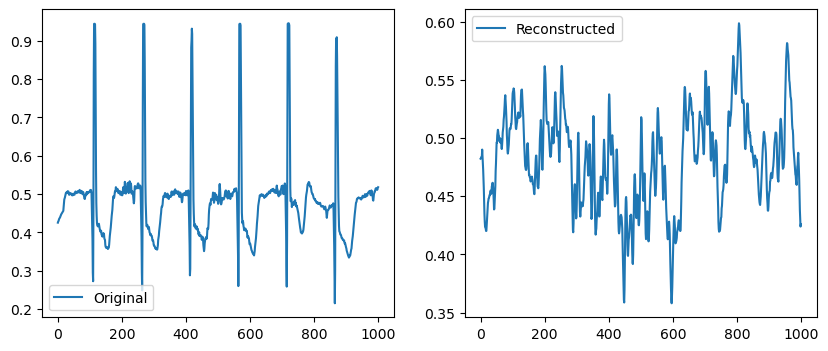

In [9]:
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 기울기 계산을 비활성화
    # 테스트 데이터셋에서 샘플을 하나 가져옵니다.
    test_sample = pulse_data[0:1].to(device)  # 예제를 위해 첫 번째 샘플을 사용
    reconstructed = model(test_sample)  # 모델을 통해 샘플을 복원합니다.

    # 원본 데이터와 복원된 데이터를 시각화합니다.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터 시각화
    plt.subplot(1, 2, 1)
    plt.plot(test_sample[0].cpu().numpy(), label='Original')
    plt.legend()
    
    # 복원된 데이터 시각화
    plt.subplot(1, 2, 2)
    plt.plot(reconstructed[0].cpu().numpy(), label='Reconstructed')
    plt.legend()
    
    plt.show()


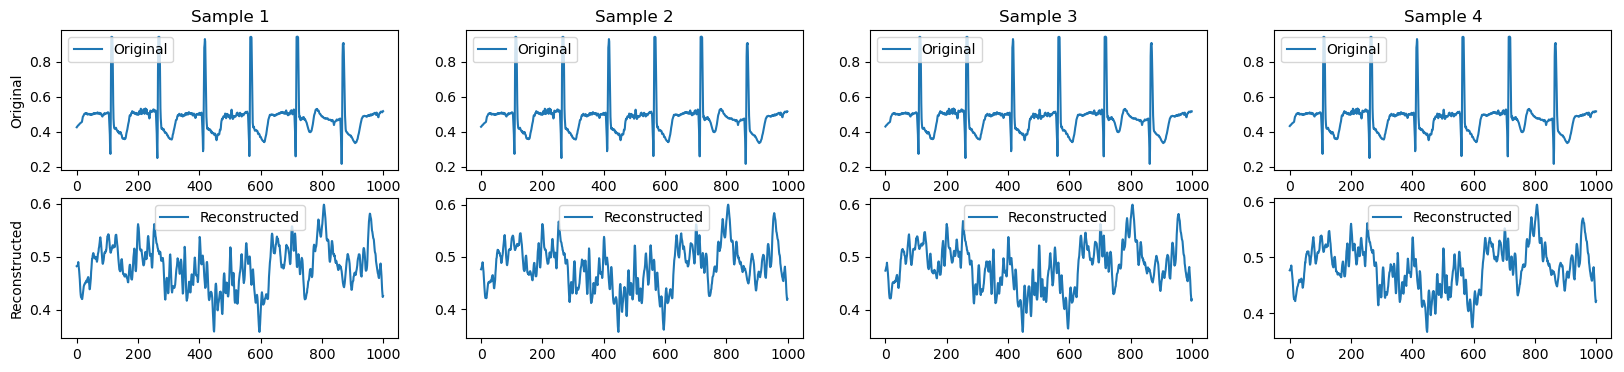

In [11]:
# 모델 평가 모드 설정
model.eval()

# 시각화를 위한 샘플 선택 (예를 들어 첫 4개 샘플)
samples_to_display = 4

# 샘플 데이터 준비
test_samples = pulse_data[:samples_to_display].to(device)  # 예제 데이터를 모델이 있는 같은 장치로 옮깁니다.
with torch.no_grad():
    # 모델을 통해 샘플 복원
    reconstructed_samples = model(test_samples)

# 시각화
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=samples_to_display, figsize=(20, 4))

for i in range(samples_to_display):
    # 원본 데이터 시각화
    axes[0, i].plot(test_samples[i].cpu().numpy(), label='Original')  # 데이터를 CPU로 옮기고 numpy 배열로 변환
    axes[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axes[0, i].set_ylabel('Original')
    axes[0, i].legend()
    
    # 복원된 데이터 시각화
    axes[1, i].plot(reconstructed_samples[i].cpu().numpy(), label='Reconstructed')  # 데이터를 CPU로 옮기고 numpy 배열로 변환
    if i == 0:
        axes[1, i].set_ylabel('Reconstructed')
    axes[1, i].legend()

plt.show()


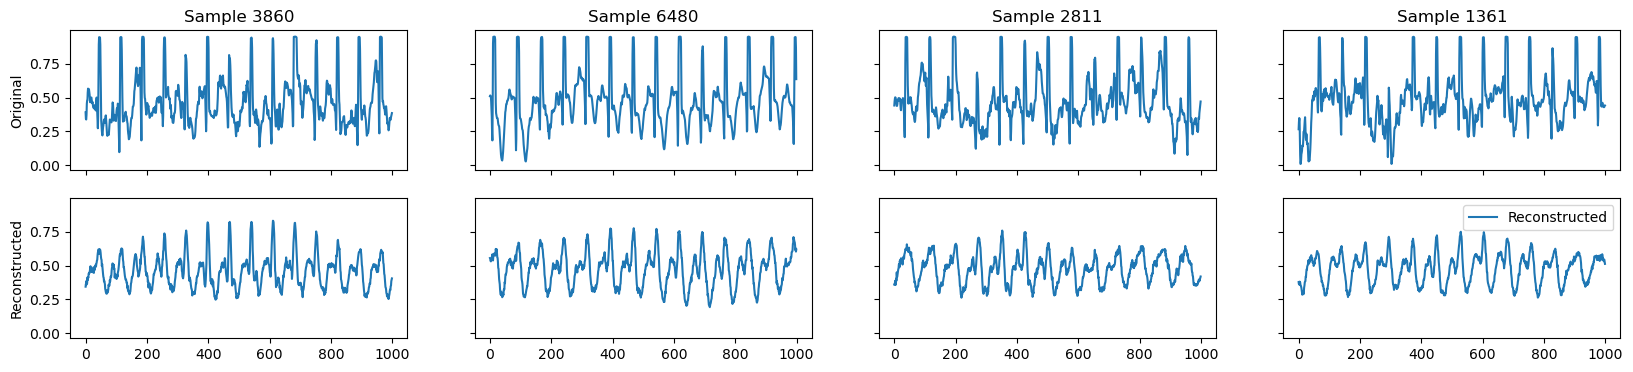

In [138]:
model.eval()

# 데이터셋에서 랜덤으로 4개의 인덱스 선택
num_samples = 4
random_indices = np.random.choice(len(pulse_data), num_samples, replace=False)

# 선택된 샘플로 Subset 생성
random_subset = Subset(pulse_data, random_indices)
# Subset을 DataLoader에 로드 (배치 크기는 선택된 샘플 수와 동일하게 설정)
random_loader = DataLoader(random_subset, batch_size=num_samples)

# DataLoader에서 데이터 배치를 가져옴
for batch in random_loader:
    test_samples = batch  # 예제에서는 pulse_data가 텐서라고 가정
    break  # 한 배치만 필요

with torch.no_grad():
    # 모델을 통해 샘플 복원
    reconstructed_samples = model(test_samples)

# 시각화
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(20, 4), sharex=True, sharey=True)

for i in range(num_samples):
    # 원본 데이터 시각화
    axes[0, i].plot(test_samples[i].numpy(), label='Original')
    axes[0, i].set_title(f'Sample {random_indices[i]+1}')
    
    # 복원된 데이터 시각화
    axes[1, i].plot(reconstructed_samples[i].numpy(), label='Reconstructed')

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Reconstructed')

plt.legend()
plt.show()


In [ ]:
len(kk)

In [ ]:
kk = LoadCsvToList("m_2.csv","data//")

In [96]:
kk = ReduceHighNoise(kk)

In [99]:
def ShowNSubplotSingleList(lst,start_idx = 0, num_idx=1000,N = 4):
    """
    시작 인덱스로 부터 지정 인덱스 만큼 지정 갯수를 plot

    lst         : input 1d array list
    N           : N개를 plot
    start_idx   : plot 시작 인덱스
    num_idx     : 인덱스 단위 
    """
    # 플롯 설정
    fig, axs = plt.subplots(N, 1, figsize=(10, 2*N))  # 4개의 서브플롯 생성
    lst = lst[start_idx:]
    # 1000개씩 데이터를 묶어 각 서브플롯에 표시
    for i in range(N):
        start_idx = i * num_idx  # 시작 인덱스
        end_idx = (i + 1) * num_idx  # 끝 인덱스
        axs[i].plot(lst[start_idx:end_idx])
        axs[i].set_title(f'Set {i+1}')

    # 전체 플롯의 레이아웃 조정
    plt.tight_layout()
    plt.show()

In [ ]:
ShowNSubplotSingleList()

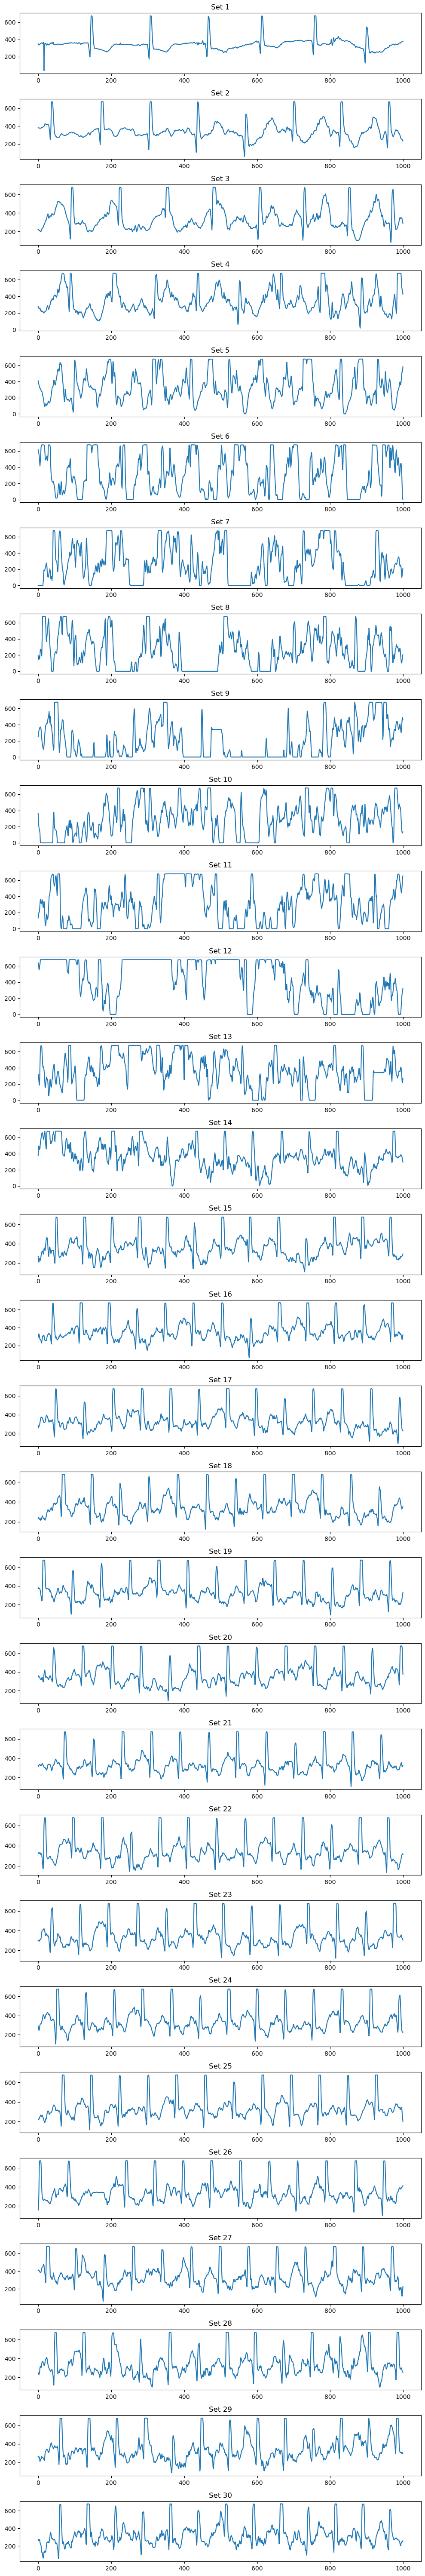

In [100]:
ShowNSubplotSingleList(kk,0,1000,30)

In [ ]:
ShowNSubplotSingleList(kk,30000,1000,30)